# BULK WEBSITE CONNECTOR

Investigative journalists often need to find information about masses of websites, for example, to find out if they connected or clustered in some ways. 

This script checks an infinite 'checklist' of addresses and finds identifiers such as Google Analytics ID, Yandex ID, WhoIs info and IP addresses.

It puts them into a dataframe and then does a network analysis that shows clusters.

In [1]:
# libraries
import requests
from bs4 import BeautifulSoup, Tag
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import networkx as nx

In [398]:
# insert links here

checklist = ['https://mobilecafe.inbet.cc/',\
             'https://inbetmaxbet-cafe.cc/',\
             'https://papabet.cc',\
             'https://www.krooncasino.cc',\
             'https://planningpoker.cc/',\
             'https://blindpoker.cc/',\
             'https://vbpoker.cc/',\
            'http://dewapoker88.cc/',\
            'http://www.goopoker.cc/',\
            'https://www.betzona.cc/',\
            'https://www.caribebet.cc/',\
            'http://roulette77.cc/',\
            'https://play2x.cc/',\
            'https://betlive.cc/',\
            'https://mg2ovo.cc/',\
            'https://www.jokerclub.cc/',\
            'https://luckygames.cc/',\
            'http://onlineslots.cc/',\
            'http://maxbet-cafe.cc/',\
            'https://betscsgo.cc/',\
            'https://incafe.inbet.cc/',\
            'https://www.flashbet.cc/',\
            'http://mybets.cc/',\
            'http://www.online-keno.cc/',\
            'https://cafe-maxbet.cc/',\
            'https://cafe.inbet.cc/',\
            'https://v-bet.cc/',\
            'https://betscsgo.cc/',\
            'https://mustangbet.cc/',\
            'https://www.12play.cc/',\
            'https://cryptobets.cc/',\
            'http://www.internetpoker.cc/',\
            #'https://www.nodepositbonus.cc/',\
            'https://www.livebet.cc/',\
            'https://www.online-craps.cc/',\
            'https://www.eatforfun.cc/',\
            'https://www.1bet2u.cc/']

### FIND IDENTIFIERS IN THE CODE

Sites that use Google Analytics need to indlude an ID tag in their code. This code can be used by a company/person on a number of sites.

This function searches for Google's UA- and (less used) pub- IDs.

It also looks for Yandex IDs - common on Russian sites.

Bespoke identifiers can also be added. I have asked the script to look for the word 'license'/'licence', and for a term I noticed on one site that I thought could link it to others.


Once the identifiers are collected, a network analysis will show clusters of sites sharing the ID.


---
You can also enter this ID into this address below to find other sites not in the Checklist: https://dnslytics.com/reverse-analytics

In [336]:
def findHeaderIdentifiers(url, s):
     
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    ua, pub, ym, license, oceanside247 = None, None, None, None, None
    
    try:
    
        #### GOOGLE ANALYTICS TAG ID UA
        j = soup.find_all("script")    
        for i in j:
            if 'UA-' in str(i):             
                ua = 'UA-' + str(i).split('UA-')[1][:12].replace('"',"'").split("'")[0]  
                
        #### GOOGLE ANALYTICS TAG ID PUB
        j = soup.find_all("script")    
        for i in j:
            if 'pub-' in str(i):             
                pub = 'pub-' + str(i).split('pub-')[1][:12].replace('"',"'").split("'")[0]

        #### YANDEX ID
        j = soup.find_all("img")
        st = 'mc.yandex.ru/watch/'
        for i in j:
            if st in str(i):
                    ym = re.search('%s(.*)%s' % (st, '" '), str(i)).group(1)
                    
                    
        if 'license' in str(soup).lower() or 'lisense' in str(soup).lower():             
            license = True
            
        # bespoke identifier
        if 'OceanSide247.com' in str(soup):             
            oceanside247 = True
                    
    except:
        print('!!!!', url)
    
    identifiers_d[s] = dict(UA=ua, PUB=pub,  YM=ym, license=license, oceanside247=oceanside247)

### FIND IP ADDRESSES

Websites have IP Addresses, and from this, the (general) location of the server housing the sites can be found. 

This does not mean that this is the comapny's headquarters: sites are often stored on servers run by tech storage giants like Cloudflare, with many, many other unrelated sites.

The CheckHost site returns three different addresses. I have always found the first is the most likely.

In [376]:
def findIPs(site,s):
        
    url = "https://check-host.net/ip-info?host=" + site
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    tables = soup.find_all('table', attrs={'class':'inside_info'})

    i = 1
    for table in tables:
        
        ip_x = 'IP_'+ str(i)
        i += 1        
        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            if len(str(cols)) < 100:
                try:
                    if cols[0] == 'IP address' or cols[0] == 'Country'  or cols[0] == 'Region'  or cols[0] == 'City':    
                        k = cols[0]
                        if cols[0] == 'Country':
                            v = cols[1].split('\n')[1]
                            v = v.replace('(','').replace(')','')
                        else:
                            v = cols[1]
                        identifiers_d[s][ip_x +': ' + k] = v
                except:
                    continue

### WHOIS finder

In [395]:
def findWhoIs(site,s):
    
    url = "https://www.whois.com/whois/" + s
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    print('WHOIS: ', url)
    
    j = soup.find("div", {"class": "df-block-raw"}).contents[1].get_text()
    j = j.split('>>> Last update')[0]
    j = j.split('\n')
    for i in j:
        try:
            k,v = i.split(':',1)
            v = v.replace('\r','').strip()
            identifiers_d[s][k] = v 
        except:
            continue

In [399]:
identifiers_d = {}
for site in checklist:
    
    s = site.replace('https','').replace('http','').replace('://','').replace('www.','').replace('/','')
    identifiers_d[s] = {}
    
    findHeaderIdentifiers(site, s) 
    findIPs(site,s)
    findWhoIs(site,s)
    
    print(s)

WHOIS:  https://www.whois.com/whois/mobilecafe.inbet.cc
mobilecafe.inbet.cc
WHOIS:  https://www.whois.com/whois/inbetmaxbet-cafe.cc
inbetmaxbet-cafe.cc
WHOIS:  https://www.whois.com/whois/papabet.cc
papabet.cc
WHOIS:  https://www.whois.com/whois/krooncasino.cc
krooncasino.cc
WHOIS:  https://www.whois.com/whois/planningpoker.cc
planningpoker.cc
WHOIS:  https://www.whois.com/whois/blindpoker.cc
blindpoker.cc
WHOIS:  https://www.whois.com/whois/vbpoker.cc
vbpoker.cc
WHOIS:  https://www.whois.com/whois/dewapoker88.cc
dewapoker88.cc
WHOIS:  https://www.whois.com/whois/goopoker.cc
goopoker.cc
WHOIS:  https://www.whois.com/whois/betzona.cc
betzona.cc
WHOIS:  https://www.whois.com/whois/caribebet.cc
caribebet.cc
WHOIS:  https://www.whois.com/whois/roulette77.cc
roulette77.cc
WHOIS:  https://www.whois.com/whois/play2x.cc
play2x.cc
WHOIS:  https://www.whois.com/whois/betlive.cc
betlive.cc
WHOIS:  https://www.whois.com/whois/mg2ovo.cc
mg2ovo.cc
WHOIS:  https://www.whois.com/whois/jokerclub.cc
jok

In [401]:
identifiersDF = pd.DataFrame.from_dict(identifiers_d).T
identifiersDF['Site'] = identifiersDF.index               ## makes the network analysis easier to refer to a clumn value, not an index value
identifiersDF

,UA,PUB,YM,license,oceanside247,IP_1: IP address,IP_1: Country,IP_1: Region,IP_1: City,IP_2: IP address,...,Billing State/Province,Billing Postal Code,Billing Country,Billing Phone,Billing Phone Ext,Billing Fax,Billing Fax Ext,Billing Email,Nameserver,Site
mobilecafe.inbet.cc,None,None,27214355,None,None,172.67.17.94,US,Illinois,Chicago,172.67.17.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobilecafe.inbet.cc
inbetmaxbet-cafe.cc,UA-15084876-7,None,27214355,None,None,104.28.1.59,CA,Quebec,Montreal,104.28.1.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inbetmaxbet-cafe.cc
papabet.cc,None,None,None,None,None,13.227.170.12,GB,England,London,13.227.170.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,papabet.cc
krooncasino.cc,UA-126467726-1,None,None,True,None,160.153.129.202,NL,North Holland,Amsterdam,160.153.129.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,krooncasino.cc
planningpoker.cc,None,None,None,None,None,13.227.170.21,GB,England,London,13.227.170.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,planningpoker.cc
blindpoker.cc,None,None,None,None,None,151.139.128.10,US,Virginia,Ashburn,151.139.128.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blindpoker.cc
vbpoker.cc,UA-147862158-1,None,None,True,None,52.0.7.30,US,Virginia,Ashburn,52.0.7.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vbpoker.cc
dewapoker88.cc,None,None,None,None,None,119.81.52.50,SG,,Singapore,119.81.52.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dewapoker88.cc
goopoker.cc,UA-148481582-1,None,None,True,None,104.28.16.177,CA,Quebec,Montreal,104.28.16.177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,goopoker.cc
betzona.cc,None,None,None,None,True,104.18.28.221,CA,Quebec,Montreal,104.18.28.221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,betzona.cc


In [431]:
# pickle

df.to_pickle("./pickledinfo.pkl")

# CLUSTERS & ANALYSIS

In [402]:
def drawGraph(graphDF, main, joiner):

    G = nx.Graph()

    ### ADD NODE
    for index, row in graphDF.iterrows():
        a = row[main]
        b = row[joiner]

        G.add_node(a)

        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row[main]
            B = row[joiner]

            if b != None:
                if b == B:
                    G.add_edge(a,A)
                    
    plt.figure(1,figsize=(15,6)) 
    pos = nx.spring_layout(G,k=0.9,iterations=80)
    nx.draw(G, pos, alpha=.5, with_labels=True, font_size=16, font_color='black', node_color="silver")
    plt.show()

### SITES LINKED BY GOOGLE UA IDENT

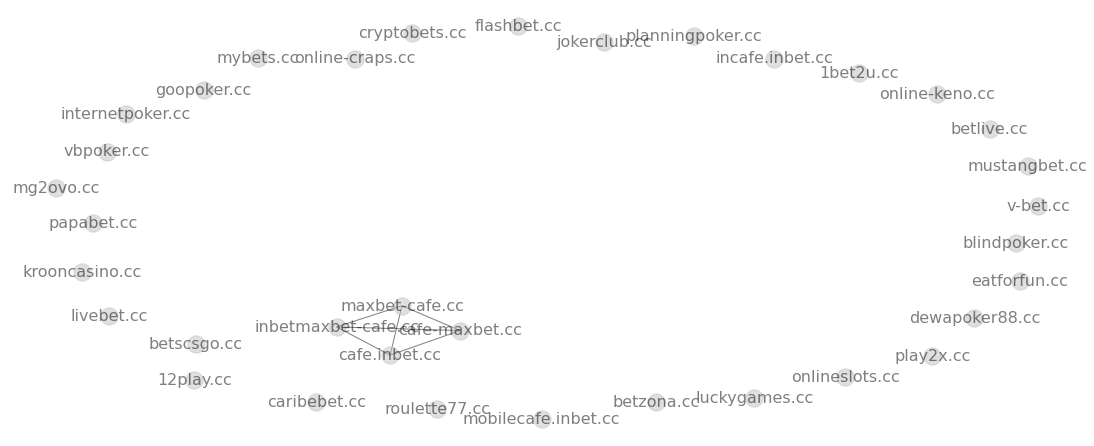

In [403]:
drawGraph(identifiersDF, 'Site', 'UA')

### SITES LINKED BY GOOGLE PUB IDENT

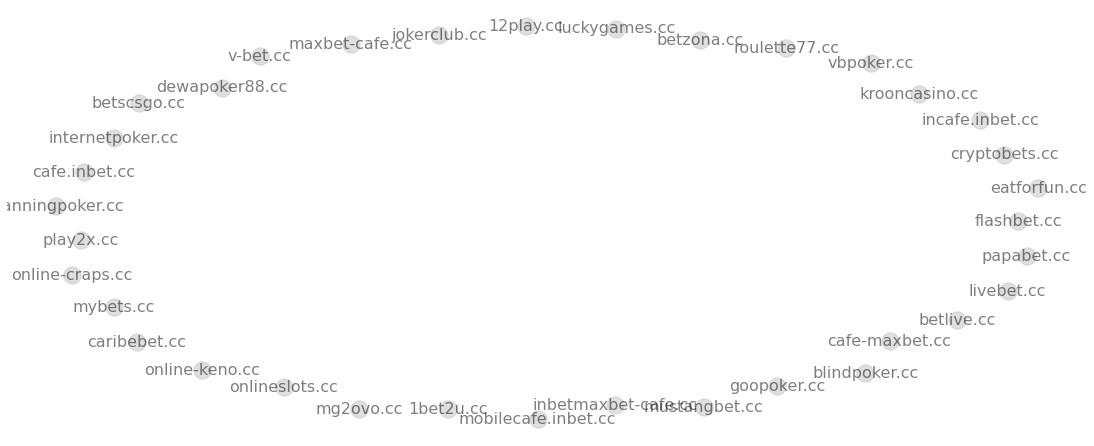

In [404]:
drawGraph(identifiersDF, 'Site', 'PUB')

### SITES LINKED BY YANDEX IDENT

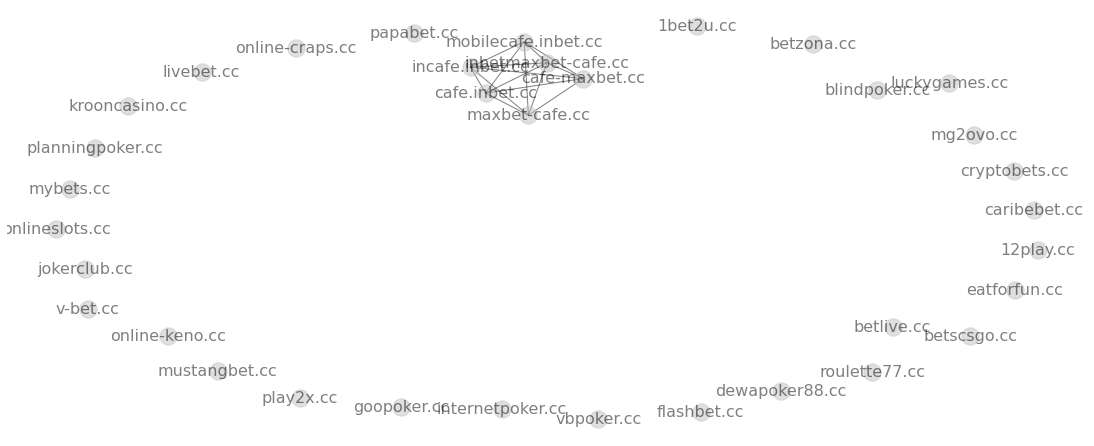

In [405]:
drawGraph(identifiersDF, 'Site', 'YM')

### SITES LINKED BY oceanside247

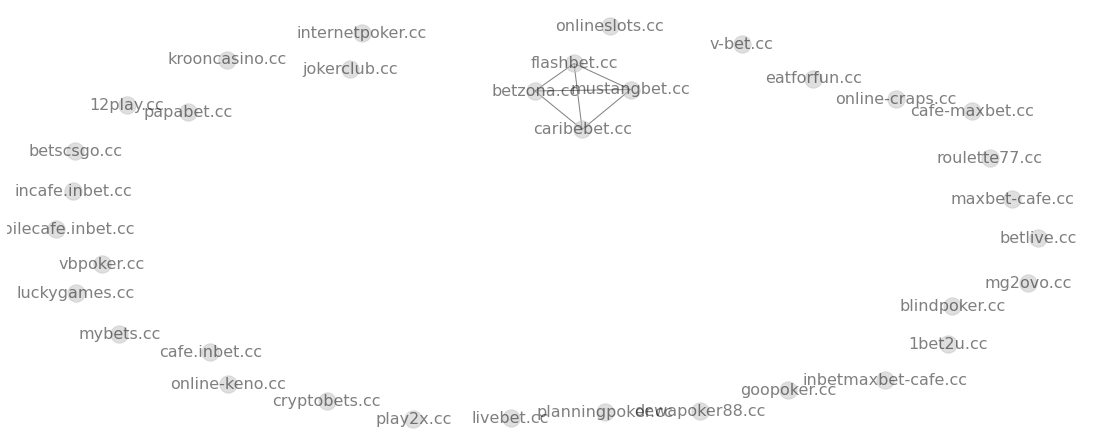

In [407]:
drawGraph(identifiersDF, 'Site', 'oceanside247')

### LICENSED SITES*

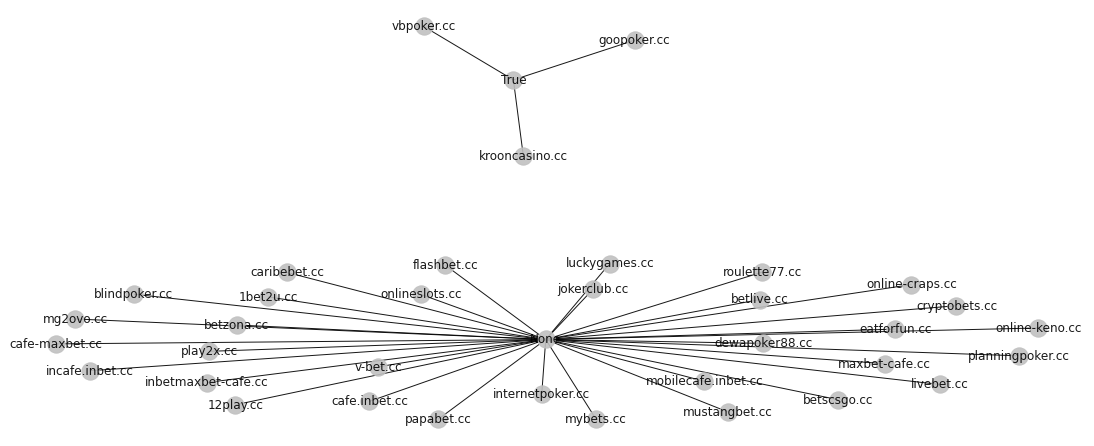

In [408]:
G = nx.Graph()
G = nx.from_pandas_edgelist(identifiersDF, 'Site', 'license')
plt.figure(1,figsize=(15,6)) 
pos = nx.spring_layout(G,k=0.15,iterations=20)
nx.draw(G, pos, alpha=.9, with_labels=True, node_color="silver", font_color="k")
plt.show()

### MULTIPLE CONNECTIONS

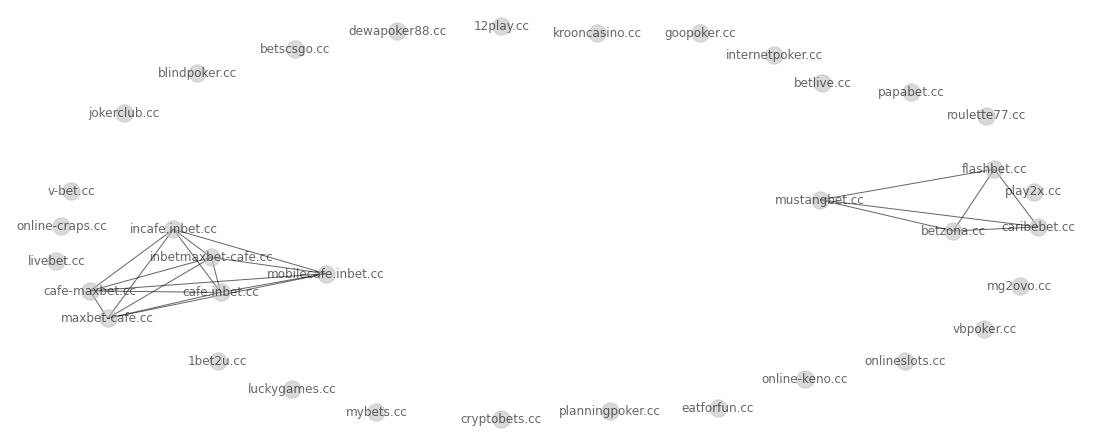

In [410]:
def multiGraph(graphDF):

    G = nx.Graph()

    ### ADD NODE
    for index, row in graphDF.iterrows():
        a = row['Site']
        
        b1 = row['UA']
        b2 = row['YM']
        b3 = row['oceanside247']

        G.add_node(a)

        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B1 = row['UA']

            if b1 != None:
                if b1 == B1:
                    G.add_edge(a,A)
                    
                    
        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B2 = row['YM']

            if b2 != None:
                if b2 == B2:
                    G.add_edge(a,A)
                    
        ## FIND EDGE
        for index, row in graphDF.iterrows():
            A = row['Site']
            B3 = row['oceanside247']

            if b3 != None:
                if b3 == B3:
                    G.add_edge(a,A)
                    
    plt.figure(1,figsize=(15,6)) 
    #nx.draw(G, alpha=.4, with_labels=True)
    pos = nx.spring_layout(G,k=1.5,iterations=100)
    nx.draw(G, pos, alpha=.6, with_labels=True, font_color="k", node_color="silver")
    plt.show()
    
multiGraph(identifiersDF)

### LOCATION OF (1st) IP ADDRESSES

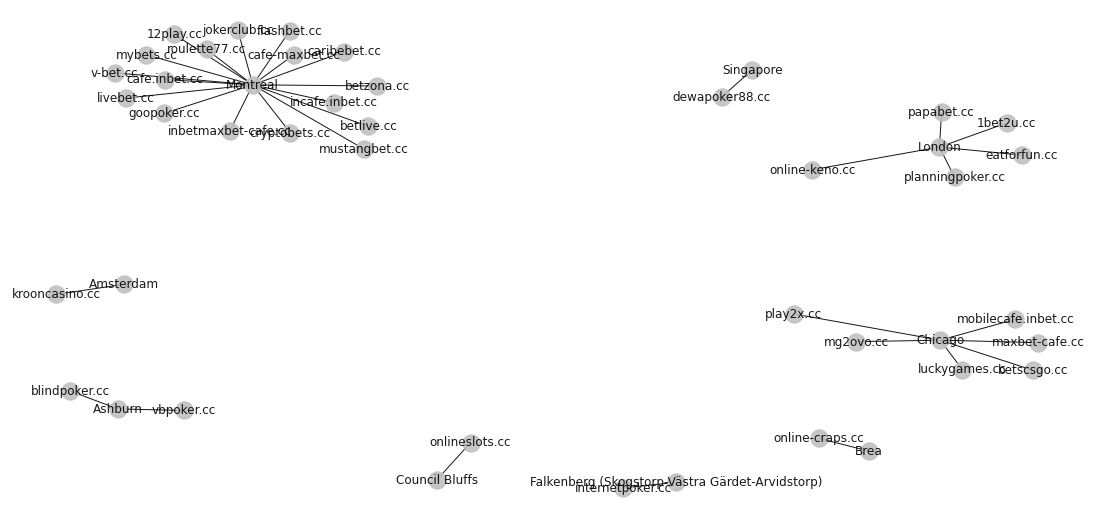

In [417]:
def drawHubs(df, field1, field2):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, field1, field2)

    plt.figure(1,figsize=(15,7)) 
    pos = nx.spring_layout(G,k=0.5,iterations=100)
    nx.draw(G, pos, alpha=.9, with_labels=True, font_color='k', node_color="silver")
    plt.show()
    
drawHubs(identifiersDF, 'IP_1: City', 'Site')

### Is location related to the company hosting their site?

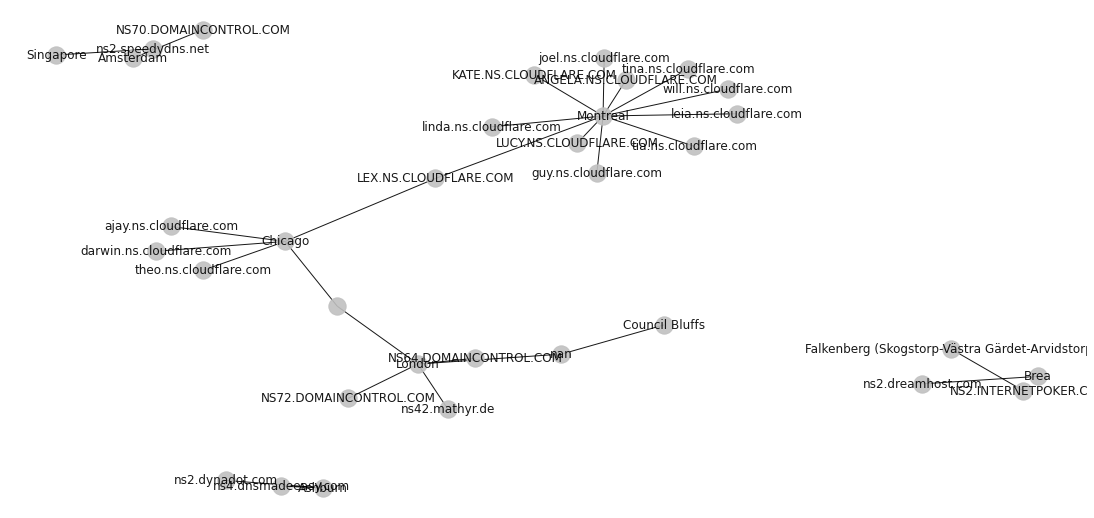

In [419]:
drawHubs(identifiersDF, 'IP_1: City', 'Name Server')

### Site Registrant Locations

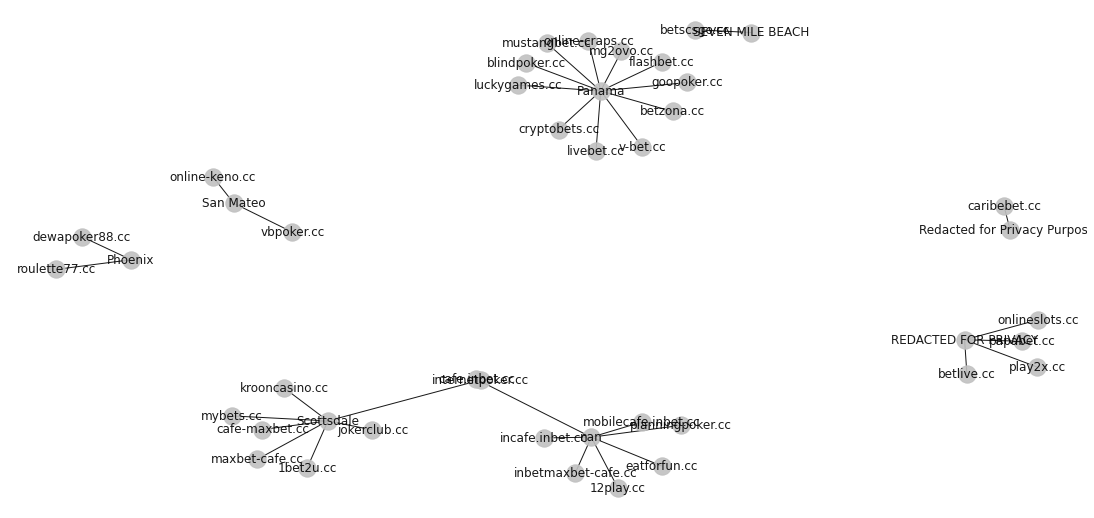

In [422]:
drawHubs(identifiersDF, 'Admin City', 'Site')

### Is that related to who is registering them (and is it a secrecy organisation)?

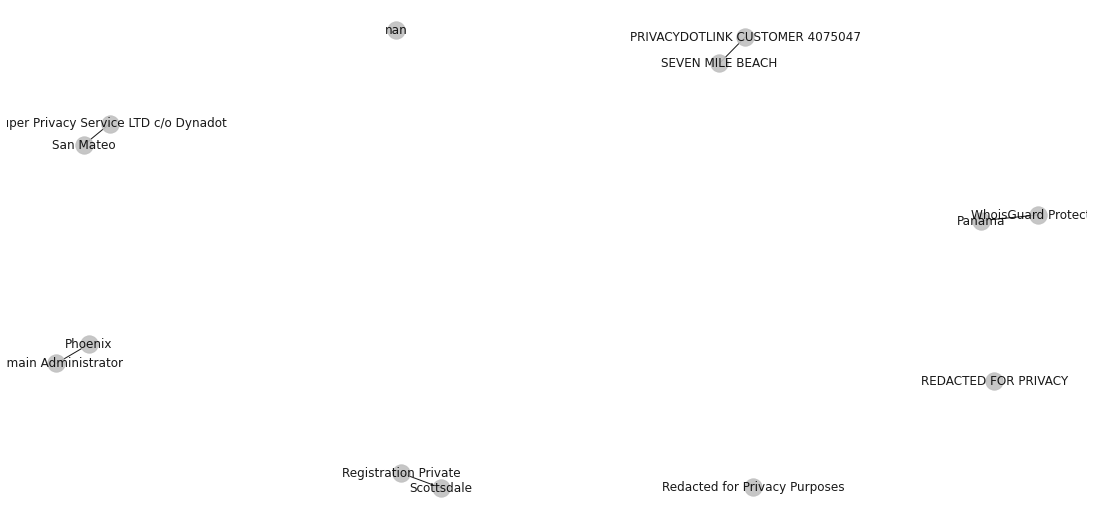

In [423]:
drawHubs(identifiersDF, 'Admin City', 'Admin Name')

# Is there a link between IP City and Registrant City? 

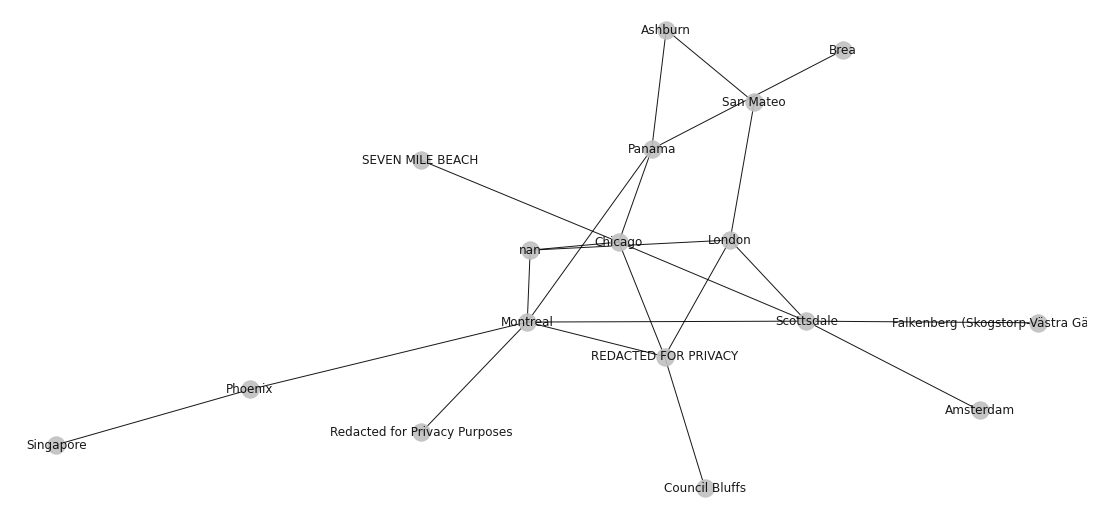

In [424]:
drawHubs(identifiersDF, 'Admin City', 'IP_1: City')

### oceanside247

An (non-automated) exploration of sites linked to a cluster of sites in the above list

In [495]:
G = nx.Graph()

#COCOS SITES WITH OCEANSIDE247 IN CODE 
G.add_edge('flashbet.cc','caribebet.cc')
G.add_edge('flashbet.cc','betzona.cc')
G.add_edge('flashbet.cc','mustangbet.cc')
G.add_edge('caribebet.cc','betzona.cc')
G.add_edge('caribebet.cc','mustangbet.cc')
G.add_edge('betzona.cc','mustangbet.cc')
G.add_edge('flashbet.cc','oceanside247.com')
G.add_edge('caribebet.cc','oceanside247.com')
G.add_edge('mustangbet.cc','oceanside247.com')
G.add_edge('betzona.cc','oceanside247.com')


# MUSTANGBET USES LUCKYDOG CODE
G.add_edge('mustangbet.cc', 'luckydog.in')

# LUCKYDOG USES OCEANSIDE247 AND SPORTACTION 77 CODE
G.add_edge('luckydog.in','oceanside247.com')
G.add_edge('luckydog.in','SportsAction77.com')

# OCEANSIDE247 USES SPORTACTION 77
G.add_edge('oceanside247.com','SportsAction77.com')


# WHOIS SAYS OCEANSIDE IS REGISTERED BY Apptitudecr IN COSTA RICA
# https://au.godaddy.com/whois/results.aspx?checkAvail=1&domain=Oceanside247.com
G.add_edge('oceanside247.com', 'APPTITUDECR')


# searches show Apptitudecr is linked to...
G.add_edge('APPTITUDECR', 'gurupropertymanagement.com')
G.add_edge('APPTITUDECR', 'mtybets.com')
G.add_edge('APPTITUDECR', 'beatpat.com')
G.add_edge('APPTITUDECR', 'kingcobrasports.com')
G.add_edge('APPTITUDECR', 'sportsaction88.net')
G.add_edge('APPTITUDECR', 'bets999.net')
G.add_edge('APPTITUDECR', 'vegasoffshore.net')
G.add_edge('APPTITUDECR', 'apuestacolombia.net')
G.add_edge('APPTITUDECR', 'buycrx.com')
G.add_edge('APPTITUDECR', 'tiempos168.com')
G.add_edge('APPTITUDECR', 'liveplaytoday.com')
G.add_edge('APPTITUDECR', 'sportsinfo27.com')
G.add_edge('APPTITUDECR', 'ipconnectcr.com')
G.add_edge('APPTITUDECR', 'infosports19.com')
G.add_edge('APPTITUDECR', 'grancasinobet.com')
G.add_edge('APPTITUDECR', 'sportsplay2.com')
G.add_edge('APPTITUDECR', 'clublv7.com')
G.add_edge('APPTITUDECR', 'sportstnt.net')
G.add_edge('APPTITUDECR', 'green4gypsy.com')
G.add_edge('APPTITUDECR', 'fwcsport.com')
G.add_edge('APPTITUDECR', 'betpitbull.com')
G.add_edge('APPTITUDECR', 'nickelonit.com')
G.add_edge('APPTITUDECR', 'juega123.com')
G.add_edge('APPTITUDECR', 'luckybuck101.com')
G.add_edge('APPTITUDECR', 'securebookie.com')
G.add_edge('APPTITUDECR', 'ufc50.com')
G.add_edge('APPTITUDECR', 'primetimeaction.net')
G.add_edge('APPTITUDECR', 'aloha22.com')
G.add_edge('APPTITUDECR', '22aloha.com')
G.add_edge('APPTITUDECR', 'brothersvip.com')
G.add_edge('APPTITUDECR', 'surfsidecr.com')
G.add_edge('APPTITUDECR', 'fireonsports.net')
G.add_edge('APPTITUDECR', 'crrentals09.com')
G.add_edge('APPTITUDECR', 'dataserverscr.com')
G.add_edge('APPTITUDECR', 'livescorecr.com')
G.add_edge('APPTITUDECR', 'cocalsports.net')
G.add_edge('APPTITUDECR', 'teaser11.net')
G.add_edge('APPTITUDECR', '182ip.com')
G.add_edge('APPTITUDECR', 'toolsbets.com')
G.add_edge('APPTITUDECR', '4quarterz.com')
G.add_edge('APPTITUDECR', 'tobysports.net')
G.add_edge('APPTITUDECR', 'sportsplay2.com')
G.add_edge('APPTITUDECR', 'betbanks2.com')



#WEBSITE INFORMERS SAYS  Apptitudecr LINKED TO EMAILs pablo2412@gmail.com, hosting@apptitudecr.com
#https://website.informer.com/Apptitudecr.html
G.add_edge('APPTITUDECR', 'pablo2412@gmail.com')
G.add_edge('APPTITUDECR', 'hosting@apptitudecr.com')
# and these sites
G.add_edge('APPTITUDECR', 'housesports77.com/')
G.add_edge('APPTITUDECR', 'liveplaytoday.com')
G.add_edge('APPTITUDECR', 'vegasoffshore.net')
G.add_edge('APPTITUDECR', 'grancasinobet.com')
# and more https://domainbigdata.com/nj/PlePTcUBedfpcmHo4GSm0g


# Searching pablo's email reveals this
# https://domainbigdata.com/gmail.com/mj/91SRB4RXW30z64NsR1_8zA
# Pablo Rosales
# +506.88663466
# info(at)pablorosales.org
# juan pable rosales
G.add_edge('pablo2412@gmail.com', '+506.88663466')
G.add_edge('pablo2412@gmail.com', 'Pablo Rosales')
G.add_edge('pablo2412@gmail.com', 'green4gypsy.com')
G.add_edge('pablo2412@gmail.com', 'vipapuestas.me')
G.add_edge('pablo2412@gmail.com', 'demotest.me')
G.add_edge('pablo2412@gmail.com', 'club2win.net')



# he links to Pablo Rosales
#https://domainbigdata.com/nj/tUd3nzIhz9q9FWqIJj762w
    
    

#G.add_edge('juan pable rosales', 'genesiscr.net')
#G.add_edge('juan pable rosales', 'taksports.net')
# and more...   https://domainbigdata.com/nj/uv-MeAI6bqoQg0bC5DqADt_w3bw4BWqQu6ZDENsfWak


'''# links in code
G.add_edge('aloha22.com', 'SportsAction77.com')
G.add_edge('oceanside247.com', 'SportsAction77.com')
G.add_edge('housesports77.com/', 'SportsAction77.com')
G.add_edge('housesports77.com/', 'oceanside247.com')
G.add_edge('cocalsports.net', 'SportsAction77.com')
G.add_edge('4quarterz.com','4quarterz.com')
G.add_edge('primeaction.com', 'SportsAction77.com')
G.add_edge('tobysports.net','SportsAction77.com')
G.add_edge('sportsplay2.com', 'SportsAction77.com')
G.add_edge('sportsplay2.com', 'oceanside247.com')
G.add_edge('bets999.net', 'SportsAction77.com')
G.add_edge('bets999.net', 'oceanside247.com')
G.add_edge( 'green4gypsy.com', 'SportsAction77.com')
G.add_edge('demotest.me','luckydog.in')
G.add_edge('demotest.me','oceanside247.com')
G.add_edge('demotest.me','SportsAction77.com')
G.add_edge('infosports19.com','oceanside247.com')
G.add_edge('infosports19.com','SportsAction77.com')
G.add_edge('liveplaytoday.com','luckydog.in')
G.add_edge('liveplaytoday.com','oceanside247.com')
G.add_edge('liveplaytoday.com','SportsAction77.com')
G.add_edge('vegasoffshore.net', 'SportsAction77.com')
G.add_edge('grancasinobet.com','oceanside247.com')
G.add_edge('grancasinobet.com','SportsAction77.com')
G.add_edge('sportsinfo27.com','luckydog.in')
G.add_edge('sportsinfo27.com','oceanside247.com')
G.add_edge('sportsinfo27.com','SportsAction77.com')
G.add_edge('youbet99.com','SportsAction77.com')
G.add_edge('aloha22.com', 'oceanside247.com')'''

"# links in code\nG.add_edge('aloha22.com', 'SportsAction77.com')\nG.add_edge('oceanside247.com', 'SportsAction77.com')\nG.add_edge('housesports77.com/', 'SportsAction77.com')\nG.add_edge('housesports77.com/', 'oceanside247.com')\nG.add_edge('cocalsports.net', 'SportsAction77.com')\nG.add_edge('4quarterz.com','4quarterz.com')\nG.add_edge('primeaction.com', 'SportsAction77.com')\nG.add_edge('tobysports.net','SportsAction77.com')\nG.add_edge('sportsplay2.com', 'SportsAction77.com')\nG.add_edge('sportsplay2.com', 'oceanside247.com')\nG.add_edge('bets999.net', 'SportsAction77.com')\nG.add_edge('bets999.net', 'oceanside247.com')\nG.add_edge( 'green4gypsy.com', 'SportsAction77.com')\nG.add_edge('demotest.me','luckydog.in')\nG.add_edge('demotest.me','oceanside247.com')\nG.add_edge('demotest.me','SportsAction77.com')\nG.add_edge('infosports19.com','oceanside247.com')\nG.add_edge('infosports19.com','SportsAction77.com')\nG.add_edge('liveplaytoday.com','luckydog.in')\nG.add_edge('liveplaytoday.c

In [496]:
color_map = []
font_map = []
for node in G:
    if ".cc" in node:
        color_map.append('royalblue')
        
    elif node == 'luckydog.in' or node == 'oceanside247.com':
        color_map.append('orange')

    elif ".com" in str(node) or ".net" in str(node) or ".in" in str(node) or ".me" in str(node): 
        color_map.append('red')

    elif node == "APPTITUDECR":
        color_map.append('yellow')
  
    else:
        color_map.append('green') 

        

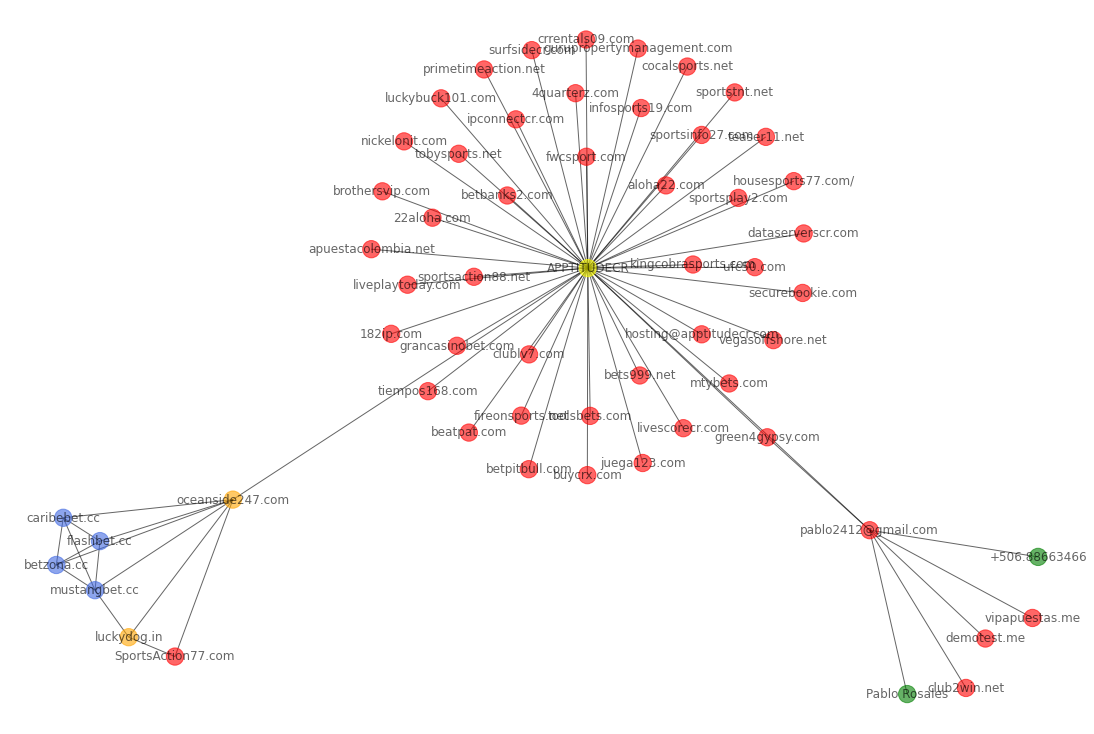

In [498]:
plt.figure(1,figsize=(15,10)) 
pos = nx.spring_layout(G,k=0.5,iterations=150)
nx.draw(G, pos, alpha=.6, with_labels=True, node_color=color_map, font_color="k")
plt.show()

In [ ]:
d = {}

def getInfo(shortname, idequals,dname, v):
        
        try:
            if v == 'A':    
                shortname = soup2.find(id=idequals).find("a").contents[0]
                
            if v == 'B':    
                shortname = soup2.find(id=idequals).find_all("td")[1].find('a').contents[0]
                            
            d[site][dname] = shortname
        except:
            pass

        
url = 'https://domainbigdata.com/nj/PlePTcUBedfpcmHo4GSm0g'
    
page = requests.get(url)                                
soup = BeautifulSoup(page.content, 'html.parser')
j = soup.find_all(id='aDomain')

for i in j:
    site = i.contents[0]
    h = 'https://domainbigdata.com' + i.get("href")
    d[site] = dict(site=site, href=h)
    
    page2 = requests.get(h)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
            
    getInfo(regname, "trRegistrantName", 'Registrant Name', 'B')
    getInfo(regorg, 'MainMaster_trRegistrantOrganization', 'Registrant Organisation', 'A')
    getInfo(regemail, "trRegistrantEmail", 'Registrant Email', 'B')
        
        
    print('.', end="")
  
df = pd.DataFrame(d).T
df

In [737]:
d = {}

def getInfo(shortname, idequals,dname, v):
        
        try:
            if v == 'A':    
                shortname = soup2.find(id=idequals).find("a").contents[0]
                
            if v == 'B':    
                shortname = soup2.find(id=idequals).find_all("td")[1].find('a').contents[0]
                            
            d[site][dname] = shortname
        except:
            shortname = None

        
url = 'https://domainbigdata.com/nj/PlePTcUBedfpcmHo4GSm0g'
    
page = requests.get(url)                                
soup = BeautifulSoup(page.content, 'html.parser')
j = soup.find_all(id='aDomain')

for i in j:
    site = i.contents[0]
    h = 'https://domainbigdata.com' + i.get("href")
    d[site] = dict(site=site, href=h)
    
    page2 = requests.get(h)
    soup2 = BeautifulSoup(page2.content, 'html.parser')
            
    getInfo(regname, "trRegistrantName", 'Registrant Name', 'B')
    getInfo(regorg, 'MainMaster_trRegistrantOrganization', 'Registrant Organisation', 'A')
    getInfo(regemail, "trRegistrantEmail", 'Registrant Email', 'B')
    

    
    # GET HISTORICAL INFO FROM EACH LINKS PAGE
    page3 = requests.get(h)                                
    soup3 = BeautifulSoup(page3.content, 'html.parser')

    j3 = soup3.find_all(id='divRptHistoryMain')

    historic = {}

    for n in range(0,len(j3)):
    
        try:
            recorded = j3[n].find(id='MainMaster_rptWhoisHistory_h2InRpt_' + str(n)).contents[0]
            recorded = recorded.split(':')[1].strip()
        except:
            recorded = None
            

        try:
            historicName  = j3[n].find(id='trRegistrantNameInRpt')               
            if historicName.find('a') != None:
                historicName = historicName.find_all("td")[1].find('a').contents[0]
            else:
                historicName = historicName.find_all("td")[1].contents[0]           
        except:
            historicName = None

        try:
            historicReg  = j3[n].find(id='MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n)).find_all("td")[1]
            if historicReg.find('a') != None:
                historicReg = historicReg.find('a').contents[0]
            else:
                historicReg = historicReg.contents[0]   
        except:
            historicReg = None


        try:
            historicEmail  = j3[n].find(id='trRegistrantEmailInRpt')               
            if historicEmail.find('a') != None:
                historicEmail = historicEmail.find_all("td")[1].find('a').contents[0]
            else:
                historicEmail = historicEmail.find_all("td")[1].contents[0]           
        except:
            historicEmail = None


        historic[n] = dict(recorded=recorded, historicName=historicName, historicReg=historicReg, historicEmail=historicEmail)
        #flatten 
        for kk, vv in historic.items():
            for k,v in historic[kk].items():
                name = k + '_' + str(kk)
                d[site][name] = v 


    print('.', end="")
    
  
  
df = pd.DataFrame(d).T
df.head()

2019-02-16
2016-09-24
....2015-06-19
..2014-07-26
.2013-08-08
.2015-09-24
.2014-09-20
.2015-01-08
.2014-12-10
.2015-01-24
..2016-10-21
2015-10-18
.2016-01-16
.2016-02-24
.2016-02-26
.2016-03-16
.2016-05-17
.2016-05-21
.2016-06-18
..2016-08-14
..2016-09-11
.2017-05-24
.....2019-02-17
..2019-02-16
.2019-02-17
.2019-02-17
...2019-04-07
2015-04-02
.

,site,href,Registrant Organisation,recorded_0,historicName_0,historicReg_0,historicEmail_0,recorded_1,historicName_1,historicReg_1,historicEmail_1,Registrant Name,Registrant Email
surfsidecr.com,surfsidecr.com,https://domainbigdata.com/surfsidecr.com,Apptitudecr,2019-02-16,None,Apptitudecr,None,2016-09-24,Contact Privacy Inc. Customer 0141346021,Contact Privacy Inc. Customer 0141346021,surfsidecr.com(at)contactprivacy.com,NaN,NaN
brothersvip.com,brothersvip.com,https://domainbigdata.com/brothersvip.com,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apptitudecr It Services,NaN
22aloha.com,22aloha.com,https://domainbigdata.com/22aloha.com,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
primetimeaction.net,primetimeaction.net,https://domainbigdata.com/primetimeaction.net,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
playmoka.com,playmoka.com,https://domainbigdata.com/playmoka.com,Apptitudecr,2015-06-19,Juan Pablo Rosales,None,None,NaN,NaN,NaN,NaN,NaN,NaN


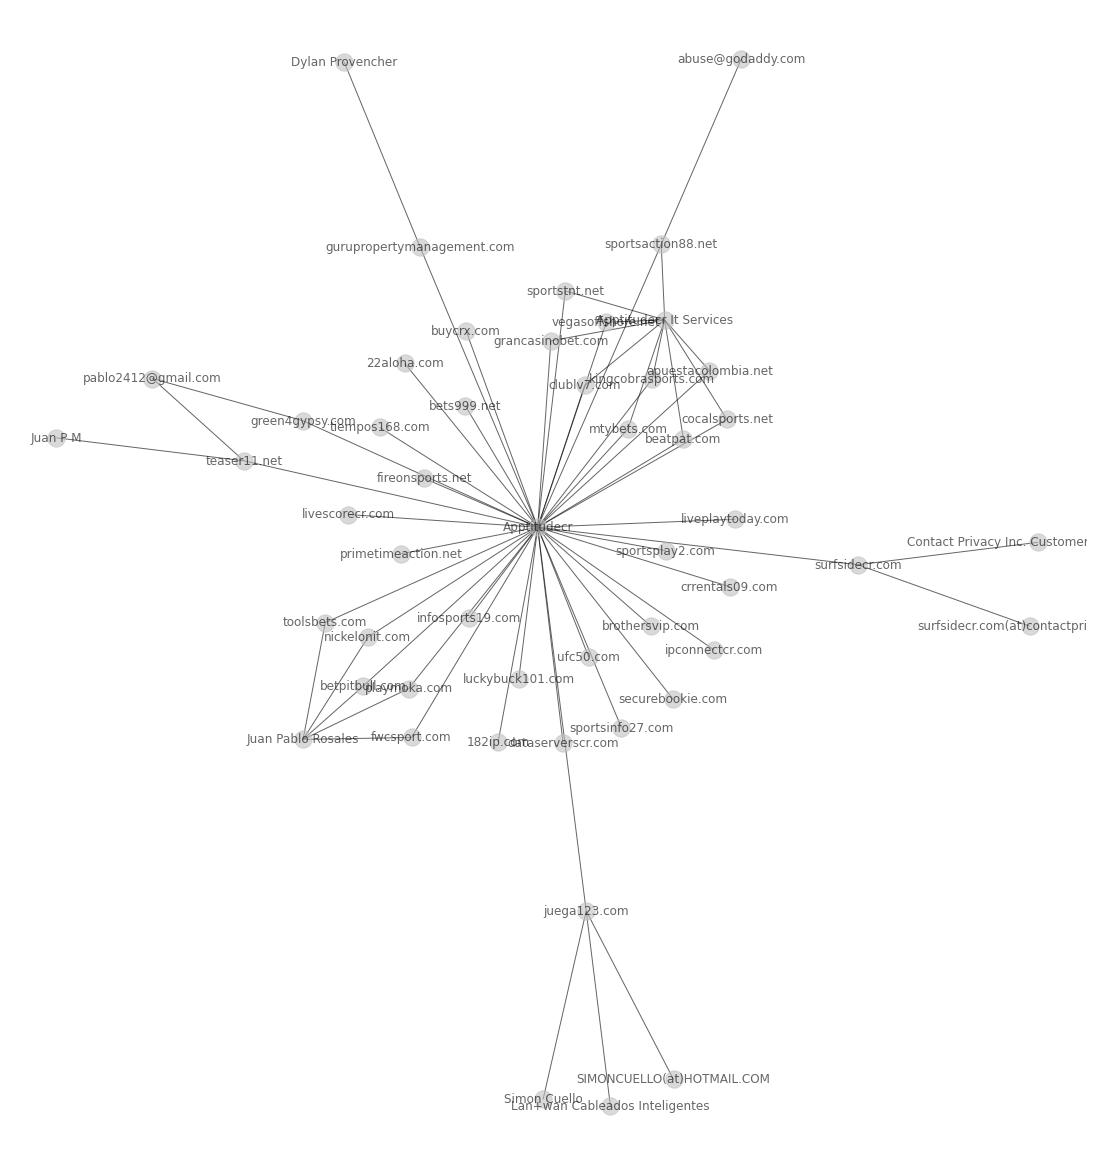

In [791]:
G = nx.Graph()

for index, row in df.iterrows():
    a = row['site']
    b = row['Registrant Organisation']
    c = row['historicReg_0']
    d = row['historicReg_1']
    e = row['historicName_0']
    f = row['historicName_1']
    g = row['historicEmail_0']
    h = row['historicEmail_1']
    i = row['Registrant Email']
    
    
    
    
    if pd.isnull(b) == False:
        if b != None:
            G.add_edge(a,b)
    if pd.isnull(c) == False:
        if c != None:
            G.add_edge(a,c)
    if pd.isnull(d) == False:
        if d != None:
            G.add_edge(a,d)
    if pd.isnull(e) == False:
        if e != None:
            G.add_edge(a,e)
    if pd.isnull(f) == False:
        if f != None:
            G.add_edge(a,f)
    if pd.isnull(g) == False:
        if g != None:
            G.add_edge(a,g)
    if pd.isnull(h) == False:
        if h != None:
            G.add_edge(a,h)
    if pd.isnull(i) == False:
        if i != None:
            G.add_edge(a,i)
    
plt.figure(1,figsize=(15,16)) 
pos = nx.spring_layout(G,k=2,iterations=1000)
nx.draw(G, pos, alpha=.6, with_labels=True, font_color="k", node_color="silver")
plt.show()

In [790]:
df

,site,href,Registrant Organisation,recorded_0,historicName_0,historicReg_0,historicEmail_0,recorded_1,historicName_1,historicReg_1,historicEmail_1,Registrant Name,Registrant Email
surfsidecr.com,surfsidecr.com,https://domainbigdata.com/surfsidecr.com,Apptitudecr,2019-02-16,None,Apptitudecr,None,2016-09-24,Contact Privacy Inc. Customer 0141346021,Contact Privacy Inc. Customer 0141346021,surfsidecr.com(at)contactprivacy.com,NaN,NaN
brothersvip.com,brothersvip.com,https://domainbigdata.com/brothersvip.com,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apptitudecr It Services,NaN
22aloha.com,22aloha.com,https://domainbigdata.com/22aloha.com,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
primetimeaction.net,primetimeaction.net,https://domainbigdata.com/primetimeaction.net,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
playmoka.com,playmoka.com,https://domainbigdata.com/playmoka.com,Apptitudecr,2015-06-19,Juan Pablo Rosales,None,None,NaN,NaN,NaN,NaN,NaN,NaN
ufc50.com,ufc50.com,https://domainbigdata.com/ufc50.com,Apptitudecr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
securebookie.com,securebookie.com,https://domainbigdata.com/securebookie.com,Apptitudecr,2014-07-26,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
luckybuck101.com,luckybuck101.com,https://domainbigdata.com/luckybuck101.com,Apptitudecr,2013-08-08,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
gurupropertymanagement.com,gurupropertymanagement.com,https://domainbigdata.com/gurupropertymanageme...,Apptitudecr,2015-09-24,Dylan Provencher,None,None,NaN,NaN,NaN,NaN,NaN,NaN
juega123.com,juega123.com,https://domainbigdata.com/juega123.com,Apptitudecr,2014-09-20,Simon Cuello,Lan+wan Cableados Inteligentes,SIMONCUELLO(at)HOTMAIL.COM,NaN,NaN,NaN,NaN,NaN,NaN


In [720]:
flattened = {}

def flatten_dict(dd, separator ='_', prefix =''): 
    
    for kk, vv in dd.items():
        for k,v in dd[kk].items():
            name = k + '_' + str(kk)
            flattened[name] = v
            
flatten_dict(historic)

flattened

{'recorded_0': 'Recorded : 2019-04-07',
 'historicName_0': None,
 'historicReg_0': 'Apptitudecr',
 'historicEmail_0': None,
 'recorded_1': 'Recorded : 2015-04-02',
 'historicName_1': 'Juan Pablo Rosales',
 'historicReg_1': None,
 'historicEmail_1': None}

In [721]:
flattened = {}
for kk, vv in historic.items():
    for k,v in historic[kk].items():
        name = k + '_' + str(kk)
        flattened[name] = v      

{'recorded_0': 'Recorded : 2019-04-07',
 'historicName_0': None,
 'historicReg_0': 'Apptitudecr',
 'historicEmail_0': None,
 'recorded_1': 'Recorded : 2015-04-02',
 'historicName_1': 'Juan Pablo Rosales',
 'historicReg_1': None,
 'historicEmail_1': None}

In [699]:
df = pd.DataFrame.from_dict({(i,j): historic[i][j] 
                           for i in historic.keys() 
                           for j in historic[i].keys()},
                           orient='index'
                       ).T

df

,"(0, recorded)","(0, historicName)","(0, historicReg)","(0, historicEmail)","(1, recorded)","(1, historicName)","(1, historicReg)","(1, historicEmail)"
0,Recorded : 2019-04-07,None,Apptitudecr,None,Recorded : 2015-04-02,Juan Pablo Rosales,None,None


{'surfsidecr.com': {'site': 'surfsidecr.com',
  'href': 'https://domainbigdata.com/surfsidecr.com',
  'Registrant Organisation': 'Apptitudecr'},
 'brothersvip.com': {'site': 'brothersvip.com',
  'href': 'https://domainbigdata.com/brothersvip.com',
  'Registrant Name': 'Apptitudecr It Services',
  'Registrant Organisation': 'Apptitudecr'},
 '22aloha.com': {'site': '22aloha.com',
  'href': 'https://domainbigdata.com/22aloha.com',
  'Registrant Organisation': 'Apptitudecr'},
 'primetimeaction.net': {'site': 'primetimeaction.net',
  'href': 'https://domainbigdata.com/primetimeaction.net',
  'Registrant Organisation': 'Apptitudecr'},
 'playmoka.com': {'site': 'playmoka.com',
  'href': 'https://domainbigdata.com/playmoka.com',
  'Registrant Organisation': 'Apptitudecr'},
 'ufc50.com': {'site': 'ufc50.com',
  'href': 'https://domainbigdata.com/ufc50.com',
  'Registrant Organisation': 'Apptitudecr'}}

In [678]:
url3 = 'https://domainbigdata.com/surfsidecr.com'
    
page3 = requests.get(url3)                                
soup3 = BeautifulSoup(page3.content, 'html.parser')

j3 = soup3.find_all(id='divRptHistoryMain')

historic = {}

for n in range(0,len(j3)):
    
    try:
        recorded = j3[n].find(id='MainMaster_rptWhoisHistory_h2InRpt_' + str(n)).contents[0]
    except:
        recorded = None
    
    
    try:
        historicName  = j3[n].find(id='trRegistrantNameInRpt')               
        if historicName.find('a') != None:
            historicName = historicName.find_all("td")[1].find('a').contents[0]
        else:
            historicName = historicName.find_all("td")[1].contents[0]           
    except:
        historicName = None
        

    try:
        historicReg  = j3[n].find(id='MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n)).find_all("td")[1]
        if historicReg.find('a') != None:
            historicReg = historicReg.find('a').contents[0]
        else:
            historicReg = historicReg.contents[0]   
    except:
        historicReg = None
        
        
    try:
        historicEmail  = j3[n].find(id='trRegistrantEmailInRpt')               
        if historicEmail.find('a') != None:
            historicEmail = historicEmail.find_all("td")[1].find('a').contents[0]
        else:
            historicEmail = historicEmail.find_all("td")[1].contents[0]           
    except:
        historicEmail = None
        
        

        

    
    
    historic[n] = dict(recorded=recorded, historicName=historicName, historicReg=historicReg, historicEmail=historicEmail)
    
    
    
    print(historic[n])
    

    
    print()
    print()
    #print(j3[0])

{'recorded': 'Recorded : 2019-02-16', 'historicName': None, 'historicReg': 'Apptitudecr', 'historicEmail': None}


{'recorded': 'Recorded : 2016-09-24', 'historicName': 'Contact Privacy Inc. Customer 0141346021', 'historicReg': 'Contact Privacy Inc. Customer 0141346021', 'historicEmail': 'surfsidecr.com(at)contactprivacy.com'}




In [ ]:
    try:                
        regname = soup2.find(id="trRegistrantName").find_all("td")[1]
        d[site]['Registrant Name'] = regname
    except:
        pass
    
    '''try:
        regorg = soup2.find(id = 'MainMaster_trRegistrantOrganization').find("a").contents[0]
        d[site]['Registrant Organisation'] = regorg
    except:
        pass'''
    
    '''try:
        regemail = soup2.find(id="trRegistrantEmail").find_all("td")[1]
        d[site]['Registrant Email'] = regemail
    except:
        pass'''

In [27]:
#df[['betlive.cc','v-bet.cc']][0:50]


registryid_df = df.T
registryid_df = registryid_df[['Registry Domain ID']]
registryid_df['Site'] = registryid_df.index
registryid_df = registryid_df[['Site','Registry Domain ID']]

x = registryid_df.groupby('Registry Domain ID').agg({'Site':lambda x: list(x)})

registryid_df = pd.merge(registryid_df, x, on="Registry Domain ID", how="outer")
registryid_df.columns = ['Site', 'Registry Domain ID', 'Shared']

registryid_df


,Site,Registry Domain ID,Shared
0,mobilecafe.inbet.cc,94849105_DOMAIN_CC-VRSN,"[mobilecafe.inbet.cc, incafe.inbet.cc, cafe.in..."
1,incafe.inbet.cc,94849105_DOMAIN_CC-VRSN,"[mobilecafe.inbet.cc, incafe.inbet.cc, cafe.in..."
2,cafe.inbet.cc,94849105_DOMAIN_CC-VRSN,"[mobilecafe.inbet.cc, incafe.inbet.cc, cafe.in..."
3,inbetmaxbet-cafe.cc,122970265_DOMAIN_CC-VRSN,[inbetmaxbet-cafe.cc]
4,papabet.cc,148689740_DOMAIN_CC-VRSN,[papabet.cc]
5,krooncasino.cc,96733834_DOMAIN_CC-VRSN,[krooncasino.cc]
6,planningpoker.cc,NaN,NaN
7,blindpoker.cc,146634521_DOMAIN_CC-VRSN,[blindpoker.cc]
8,vbpoker.cc,144835823_DOMAIN_CC-VRSN,[vbpoker.cc]
9,dewapoker88.cc,150101584_DOMAIN_CC-VRSN,[dewapoker88.cc]


In [64]:
id_df = pd.merge(gID_df, ym_df)

id_df = pd.merge(id_df, registryid_df, on="Site")

id_df

,Site,Google Analytics Tag ID,Sites with same Google Analytics Tag ID,Yandex ID,Shared ID,Registry Domain ID,Shared
0,mobilecafe.inbet.cc,None,NaN,27214355,"[mobilecafe.inbet.cc, inbetmaxbet-cafe.cc, max...",94849105_DOMAIN_CC-VRSN,"[mobilecafe.inbet.cc, incafe.inbet.cc, cafe.in..."
1,papabet.cc,None,NaN,None,NaN,148689740_DOMAIN_CC-VRSN,[papabet.cc]
2,planningpoker.cc,None,NaN,None,NaN,NaN,NaN
3,blindpoker.cc,None,NaN,None,NaN,146634521_DOMAIN_CC-VRSN,[blindpoker.cc]
4,dewapoker88.cc,None,NaN,None,NaN,150101584_DOMAIN_CC-VRSN,[dewapoker88.cc]
5,betzona.cc,None,NaN,None,NaN,150172195_DOMAIN_CC-VRSN,[betzona.cc]
6,caribebet.cc,None,NaN,None,NaN,130046169_DOMAIN_CC-VRSN,[caribebet.cc]
7,play2x.cc,None,NaN,None,NaN,147489192_DOMAIN_CC-VRSN,[play2x.cc]
8,mg2ovo.cc,None,NaN,None,NaN,144760685_DOMAIN_CC-VRSN,[mg2ovo.cc]
9,jokerclub.cc,None,NaN,None,NaN,145601969_DOMAIN_CC-VRSN,[jokerclub.cc]


In [65]:
gID_df = gID_df.T

columns = gID_df.loc['Site'].tolist()
gID_df.columns = columns
gID_df = gID_df.drop('Site')
gID_df

,mobilecafe.inbet.cc,papabet.cc,planningpoker.cc,blindpoker.cc,dewapoker88.cc,betzona.cc,caribebet.cc,play2x.cc,mg2ovo.cc,jokerclub.cc,...,krooncasino.cc,vbpoker.cc,goopoker.cc,roulette77.cc,betlive.cc,onlineslots.cc,v-bet.cc,12play.cc,cryptobets.cc,nodepositbonus.cc
Google Analytics Tag ID,None,None,None,None,None,None,None,None,None,None,...,UA-126467726-1,UA-147862158-1,UA-148481582-1,UA-117353870-3,UA-121078155-1,UA-11981186-5,UA-158702578-1,UA-72251771-1,UA-116652613-1,UA-3280977-2
Sites with same Google Analytics Tag ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[krooncasino.cc],[vbpoker.cc],[goopoker.cc],[roulette77.cc],[betlive.cc],[onlineslots.cc],[v-bet.cc],[12play.cc],[cryptobets.cc],[nodepositbonus.cc]


In [66]:
df = df.append(gID_df)
df

,mobilecafe.inbet.cc,inbetmaxbet-cafe.cc,papabet.cc,krooncasino.cc,planningpoker.cc,blindpoker.cc,vbpoker.cc,dewapoker88.cc,goopoker.cc,betzona.cc,...,v-bet.cc,mustangbet.cc,12play.cc,cryptobets.cc,internetpoker.cc,nodepositbonus.cc,livebet.cc,online-craps.cc,eatforfun.cc,1bet2u.cc
IP_1: IP address,172.67.17.94,104.28.0.59,143.204.215.21,160.153.129.202,143.204.215.42,151.139.128.10,52.0.7.30,119.81.52.50,104.28.16.177,104.18.29.221,...,172.67.165.26,104.18.19.201,104.31.64.220,104.28.15.16,178.73.227.73,67.227.207.90,104.28.7.205,67.205.14.93,99.86.7.64,143.204.215.116
IP_1: Country,US,CA,DE,NL,DE,US,US,SG,CA,CA,...,US,CA,CA,CA,SE,US,CA,US,DE,DE
IP_1: Region,Illinois,Quebec,Hesse,North Holland,Hesse,Virginia,Virginia,,Quebec,Quebec,...,Illinois,Quebec,Quebec,Quebec,Halland,Georgia,Quebec,California,Hesse,Hesse
IP_1: City,Chicago,Montreal,Frankfurt am Main,Amsterdam,Frankfurt am Main,Ashburn,Ashburn,Singapore,Montreal,Montreal,...,Chicago,Montreal,Montreal,Montreal,Falkenberg (Skogstorp-Västra Gärdet-Arvidstorp),Cumming,Montreal,Brea,Frankfurt am Main,Frankfurt am Main
IP_2: IP address,172.67.17.94,104.28.0.59,143.204.215.21,160.153.129.202,143.204.215.42,151.139.128.10,52.0.7.30,119.81.52.50,104.28.16.177,104.18.29.221,...,172.67.165.26,104.18.19.201,104.31.64.220,104.28.15.16,178.73.227.73,67.227.207.90,104.28.7.205,67.205.14.93,99.86.7.64,143.204.215.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Billing Fax Ext,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Billing Email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nameserver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Google Analytics Tag ID,None,UA-15084876-7,None,UA-126467726-1,None,None,UA-147862158-1,None,UA-148481582-1,None,...,UA-158702578-1,None,UA-72251771-1,UA-116652613-1,None,UA-3280977-2,None,None,None,None


-----

It can also be worth looking for 'pub-', but in these sites, I found nothing. 

Also worth checking out:

https://securitytrails.com/
https://mxtoolbox.com/
https://dnslytics.com/reverse-analytics
https://analyzeid.com/

In [266]:
#x = df.loc['Billing Email'] 
#x.value_counts()    
        
#df.loc[:,df.loc['Creation Date'] == '2016-05-25T04:44:38Z']

@domain-contact.org    1
Name: Billing Email, dtype: int64